# 1. Imports

In [1]:
import sys
sys.path.insert(0, './../src')

import json
import pandas as pd
from datetime import datetime
from math import radians, cos, sin, asin, sqrt

# 2. Collect data

In [2]:
from ztmwarsaw.api.BusCaller import BusCaller
from ztmwarsaw.tracker.BusTracker import BusTracker

buscaller = BusCaller(apikey="54b839d9-364d-4877-ae15-a624352175a3")
bustracker = BusTracker(buscaller)
# result = bustracker.track(duration=3600, frequency=10, filepath="data.txt")

# 3. Analysis

### 3.1 Read data

In [3]:
data = []
with open('data.txt', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df["VehicleNumber"] = df["VehicleNumber"].astype(int)
df["Time"] = pd.to_datetime(df["Time"])
print("Size before dropping duplicates:", df.shape[0])
df.drop_duplicates(inplace=True)
print("Size after dropping duplicates:", df.shape[0])

Size before dropping duplicates: 487073
Size after dropping duplicates: 314795


### 3.2 How many buses exceeded 90km/h?

In [5]:
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

In [49]:
df.sort_values(by=['VehicleNumber', 'Time'], inplace=True)

df['Time'] = pd.to_datetime(df['Time'])
df['Time_diff'] = df.groupby('VehicleNumber')['Time'].diff().dt.total_seconds() / 3600
df['Time_diff2'] = df.groupby('VehicleNumber')['Time'].diff(periods=2).dt.total_seconds() / 3600
df['Lat_shifted'] = df.groupby('VehicleNumber')['Lat'].shift(-1)
df['Lon_shifted'] = df.groupby('VehicleNumber')['Lon'].shift(-1)
df['Lat_shifted2'] = df.groupby('VehicleNumber')['Lat'].shift(-2)
df['Lon_shifted2'] = df.groupby('VehicleNumber')['Lon'].shift(-2)
df['Distance_km'] = df.apply(lambda row: haversine_distance(row['Lon'], row['Lat'], row['Lon_shifted'], row['Lat_shifted']), axis=1)
df['Distance_km2'] = df.apply(lambda row: haversine_distance(row['Lon'], row['Lat'], row['Lon_shifted2'], row['Lat_shifted2']), axis=1)

df['Speed_km_h'] = df['Distance_km'] / df['Time_diff']
df['Speed_km_h2'] = df['Distance_km2'] / df['Time_diff2']

#### Period = 1

In [97]:
buses_exceeding_90kmh = df[(df['Speed_km_h2'] > 90)]['VehicleNumber'].nunique()
print(f"Buses exceeding 90 km/h: {buses_exceeding_90kmh}")
buses_exceeding_90kmh = df[(df['Speed_km_h'] > 90) & (df['Time_diff'] > 50 / 3600)]['VehicleNumber'].nunique()
print(f"Buses exceeding 90 km/h in 45 seconds period: {buses_exceeding_90kmh}")

Buses exceeding 90 km/h: 761
Buses exceeding 90 km/h in 45 seconds period: 12


#### Period = 2

In [98]:
buses_exceeding_90kmh = df[(df['Speed_km_h2'] > 90)]['VehicleNumber'].nunique()
print(f"Buses exceeding 90 km/h: {buses_exceeding_90kmh}")
buses_exceeding_90kmh_60sec = df[(df['Speed_km_h2'] > 90) & (df['Time_diff'] > 50 / 3600)]['VehicleNumber'].nunique()
print(f"Buses exceeding 90 km/h in 45 seconds period: {buses_exceeding_90kmh_60sec}")

Buses exceeding 90 km/h: 761
Buses exceeding 90 km/h in 45 seconds period: 4


### 3.3 How many buses exceeded 50km/h?

#### Period = 1

In [107]:
all_buses = df['VehicleNumber'].nunique()
print(f"All busses: {all_buses}")
buses_exceeding_50kmh = df[(df['Speed_km_h'] > 50)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h: {buses_exceeding_50kmh}")
buses_exceeding_50kmh_under_90kmh = df[(df['Speed_km_h'] > 50) & (df['Speed_km_h'] < 90)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h but not 90km/h: {buses_exceeding_50kmh_under_90kmh}")
buses_exceeding_50kmh_60sec = df[(df['Speed_km_h'] > 50) & (df['Speed_km_h'] < 90) & (df['Time_diff'] > 60 / 3600)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h but not 90km/h in 60 second period: {buses_exceeding_50kmh_60sec}")
print(f"{100 * buses_exceeding_50kmh_60sec / all_buses:.2f}%")

All busses: 1761
Buses exceeding 50 km/h: 1156
Buses exceeding 50 km/h but not 90km/h: 1153
Buses exceeding 50 km/h but not 90km/h in 60 second period: 149
8.46%


#### Period = 2

In [109]:
print(f"All busses: {df['VehicleNumber'].nunique()}")
buses_exceeding_50kmh = df[(df['Speed_km_h2'] > 50)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h: {buses_exceeding_50kmh}")
buses_exceeding_50kmh_under_90kmh = df[(df['Speed_km_h2'] > 50) & (df['Speed_km_h2'] < 90)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h but not 90km/h: {buses_exceeding_50kmh_under_90kmh}")
buses_exceeding_50kmh_90sec = df[(df['Speed_km_h2'] > 50) & (df['Speed_km_h2'] < 90) & (df['Time_diff2'] > 90 / 3600)]['VehicleNumber'].nunique()
print(f"Buses exceeding 50 km/h but not 90km/h in 90 second period: {buses_exceeding_50kmh_90sec}")
print(f"{100 * buses_exceeding_50kmh_90sec / all_buses:.2f}%")

All busses: 1761
Buses exceeding 50 km/h: 1126
Buses exceeding 50 km/h but not 90km/h: 1124
Buses exceeding 50 km/h but not 90km/h in 90 second period: 172
9.77%


# 4. Visualisations

### 4.1 Path of bus 157.

In [77]:
import pandas as pd
from PIL import Image
import folium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import io
import time

def create_gif_for_vehicle(vehicle_number, period=5, duration=500):
    vehicle_df = df[df['VehicleNumber'] == vehicle_number].sort_values(by='Time')
    
    images = []

    for idx, (index, row) in enumerate(vehicle_df.iterrows()):
        if idx % period == 0:
            options = Options()
            options.add_argument("--headless")
            options.add_argument('--disable-blink-features=AutomationControlled')
            driver = webdriver.Chrome(options=options)
            
            folium_map = folium.Map(location=[row['Lat'], row['Lon']], zoom_start=14)
            folium.Marker([row['Lat'], row['Lon']]).add_to(folium_map)
            map_html = 'temp_map.html'
            folium_map.save(map_html)
            
            png = folium_map._to_png(1, driver=driver)
            image = Image.open(io.BytesIO(png))
            images.append(image)
    
            driver.quit()

    print(f"Collected {len(images)} images.")

    gif_filename = f'vehicle_{vehicle_number}_tracking.gif'
    images[0].save(gif_filename,
                   save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)
    print(f'GIF saved as {gif_filename}')

In [80]:
create_gif_for_vehicle(9424, period=2, duration=150)

(277, 16)
Collected 139 images
GIF saved as vehicle_9424_tracking.gif


### 4.2 Places where buses exceeded 50km/h

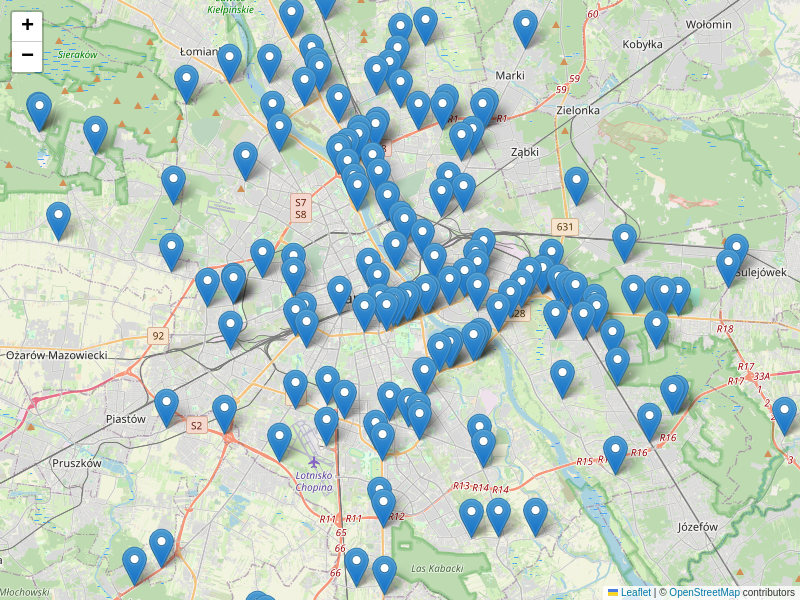

In [114]:
filtered_df = df[(df['Speed_km_h'] > 50) & (df['Speed_km_h'] < 90) & (df['Time_diff'] > 60 / 3600)]

center_lat = filtered_df['Lat'].mean()
center_lon = filtered_df['Lon'].mean()
folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for index, row in filtered_df.iterrows():
    folium.Marker([row['Lat'], row['Lon']]).add_to(folium_map)

options = Options()
options.add_argument("--headless")
options.add_argument('--disable-blink-features=AutomationControlled')
driver = webdriver.Chrome(options=options)

map_html = 'map_with_markers.html'
folium_map.save(map_html)
png = folium_map._to_png(1, driver=driver)
image = Image.open(io.BytesIO(png))
image